In [2]:
# TensorFlow and tf.keras
import tensorflow as tf

import keras
import keras.backend
from keras import layers
from keras import models
from keras import optimizers
import keras.utils
import pandas as pd

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
#import h5py
import math
import time
import sklearn
from sklearn.utils import shuffle

import innvestigate
import innvestigate.utils as iutils

import os

1.13.1


In [3]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
          #'text.color': 'white',
          #'axes.labelcolor': 'white',
          #'xtick.color':'white',
          #'ytick.color': 'white'
         }
# plt.rc('font', family='default')
# plt.rcParams['figure.dpi'] = 115
plt.rcParams.update(params)
plt.style.context('default')

In [4]:
grid=16

In [5]:
# testing data : 20,000 signal samples and 20,000 bkg samples
data_test = np.load('data/jetImagesTest.npz')

In [6]:
'''lrp rule : 'lrp', 'lrp.z', 'lrp.z_IB', 'lrp.epsilon', 'lrp.epsilon_IB',
              'lrp.w_square', 'lrp.flat', 'lrp.alpha_beta', 'lrp.alpha_2_beta_1',
              'lrp.alpha_2_beta_1_IB', 'lrp.alpha_1_beta_0', 'lrp.alpha_1_beta_0_IB',
              'lrp.z_plus', 'lrp.z_plus_fast', 'lrp.sequential_preset_a',
              'lrp.sequential_preset_b', 'lrp.sequential_preset_a_flat',
              'lrp.sequential_preset_b_flat' ''' 
# _IB -> Ignore Bias
def GetRelevance(model, lrp_rule, data_image):
    '''Inputs: model_name - keras.model,
               lrp_rule - str, data - array of shape (n, 1,grid,grid,1)'''
    model_ws = iutils.keras.graph.model_wo_softmax(model)
    lrp_analyzer = innvestigate.create_analyzer(lrp_rule, model_ws)
    start = time.time()
    data_image=data_image.reshape(len(data_image), 1, grid, grid, 1)
    rel_scores = [lrp_analyzer.analyze(
        [data_image[i]]) for i in range(len(data_image))]
    print('time = ', time.time()-start)
    return rel_scores

In [7]:
import keras
from keras.models import load_model
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
    model1 = load_model('model/CNN2D.h5')
    model2 = load_model('model/CNN2D_2.h5')
    model3 = load_model('model/CNN2D_3.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [8]:
model1.summary(), model2.summary(), model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 16, 16, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 32)        832       
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 32)        9248      
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 32)        4128      
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 8, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense1 (Dense)               (None, 64)                131136    
__________

(None, None, None)

In [9]:
results_model1 = model1.evaluate(data_test['jetImages'], data_test['labels'])
results_model2 = model2.evaluate(data_test['jetImages'], data_test['labels'])
results_model3 = model3.evaluate(data_test['jetImages'], data_test['labels'])

40000/40000 [==============================] - 7s 181us/step


In [10]:
np.set_printoptions(precision=4, suppress=True)
print("Model 1: ", results_model1)
print("Model 2: ", results_model2)
print("Model 3: ", results_model3)

Model 1:  [0.05026785767930851, 0.011419600808085607, 0.05026785767930851, 0.98555]
Model 2:  [0.045998963705758796, 0.01111547074329047, 0.045998963705758796, 0.985925]
Model 3:  [0.050408986751837435, 0.012170937410529114, 0.050408986751837435, 0.984675]


In [11]:
predict1 = model1.predict(data_test['jetImages'])
predict2 = model2.predict(data_test['jetImages'])
predict3 = model3.predict(data_test['jetImages'])

In [12]:
from sklearn.metrics import roc_curve, auc
fpr1, tpr1, thresholds1 = roc_curve(data_test['labels'][:,1], predict1[:,1])
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, thresholds2 = roc_curve(data_test['labels'][:,1], predict2[:,1])
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, thresholds3 = roc_curve(data_test['labels'][:,1], predict3[:,1])
roc_auc3 = auc(fpr3, tpr3)

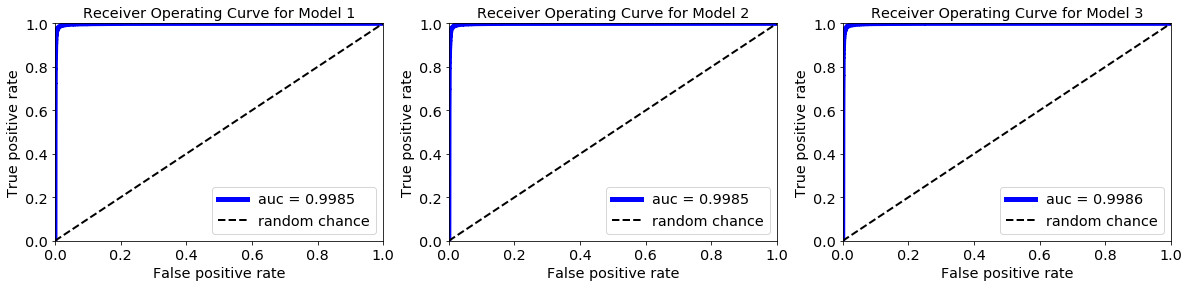

In [13]:
# Plot ROC for Signal ID
x=[0, 1]
y=[0, 1]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
fig.subplots_adjust(wspace =0.2)
axs=axs.flatten()
    
for i in range(len(axs)):
    if i==0:
        fpr = fpr1
        tpr = tpr1
        roc_auc=roc_auc1
    elif i==1:
        fpr = fpr2
        tpr = tpr2
        roc_auc=roc_auc2
    else:
        fpr = fpr3
        tpr = tpr3
        roc_auc=roc_auc3
    axs[i].plot(fpr, tpr, lw=5, color='b', label='auc = %.4f' % (roc_auc))
    axs[i].plot(x, y, linestyle='--', lw=2, color='k', label='random chance')
    axs[i].set_xlim([0, 1.0])
    axs[i].set_ylim([0, 1.0])
    axs[i].set_xlabel('False positive rate')
    axs[i].set_ylabel('True positive rate')
    axs[i].set_title('Receiver Operating Curve for Model {}'.format(i+1))
    axs[i].legend(loc="lower right")
plt.show()

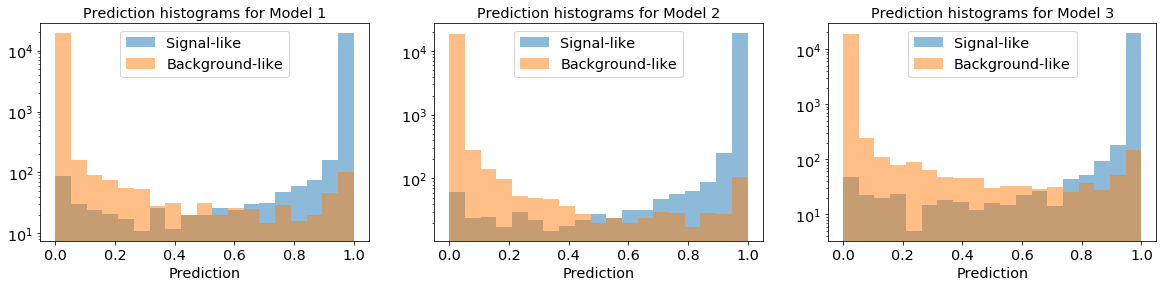

In [14]:
bins = np.linspace(0, 1, 20)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
fig.subplots_adjust(wspace =0.2)
axs=axs.flatten()
    
for i in range(len(axs)):
    if i==0:
        sig = predict1[(data_test['labels'][:,1]==1)][:,1]
        bkg = predict1[(data_test['labels'][:,0]==1)][:,1]
    elif i==1:
        sig = predict2[(data_test['labels'][:,1]==1)][:,1]
        bkg = predict2[(data_test['labels'][:,0]==1)][:,1]
    else:
        sig = predict3[(data_test['labels'][:,1]==1)][:,1]
        bkg = predict3[(data_test['labels'][:,0]==1)][:,1]
    axs[i].hist(sig, bins, alpha=0.5, label='Signal-like')
    axs[i].hist(bkg, bins, alpha=0.5, label='Background-like')
    axs[i].legend(loc="best")
    axs[i].set_xlabel('Prediction')
    axs[i].set_title('Prediction histograms for Model {}'.format(i+1))
    axs[i].set_yscale('log')
plt.show()

In [15]:
cut = 0.7

In [16]:
index1 = np.argwhere((data_test['labels'][:,1]==1)&(predict1[:,1]>cut)) # True Positive - correctly precited as Signal

index2 = np.argwhere((data_test['labels'][:,0]==1)&(predict1[:,1]>cut)) # False Positive - precited as Signal but is a Background image

index3 = np.argwhere((data_test['labels'][:,1]==1)&(predict1[:,1]<=cut)) # False Negative - precited as Background but is a Signal image

index4 = np.argwhere((data_test['labels'][:,0]==1)&(predict1[:,1]<=cut)) # True Negative - correctly precited as Background

In [17]:
index1_2 = np.argwhere((data_test['labels'][:,1]==1)&(predict2[:,1]>cut)) # True Positive - correctly precited as Signal

index2_2 = np.argwhere((data_test['labels'][:,0]==1)&(predict2[:,1]>cut)) # False Positive - precited as Signal but is a Background image

index3_2 = np.argwhere((data_test['labels'][:,1]==1)&(predict2[:,1]<=cut)) # False Negative - precited as Background but is a Signal image

index4_2 = np.argwhere((data_test['labels'][:,0]==1)&(predict2[:,1]<=cut)) # True Negative - correctly precited as Background

In [18]:
index1_3 = np.argwhere((data_test['labels'][:,1]==1)&(predict3[:,1]>cut)) # True Positive - correctly precited as Signal

index2_3 = np.argwhere((data_test['labels'][:,0]==1)&(predict3[:,1]>cut)) # False Positive - precited as Signal but is a Background image

index3_3 = np.argwhere((data_test['labels'][:,1]==1)&(predict3[:,1]<=cut)) # False Negative - precited as Background but is a Signal image

index4_3 = np.argwhere((data_test['labels'][:,0]==1)&(predict3[:,1]<=cut)) # True Negative - correctly precited as Background

In [19]:
signal_eff1 = np.sum(index1)/(np.sum(index1)+np.sum(index2))
signal_eff2 = np.sum(index1_2)/(np.sum(index1_2)+np.sum(index2_2))
signal_eff3 = np.sum(index1_3)/(np.sum(index1_3)+np.sum(index2_3))
print("Signal Efficiency: ", signal_eff1, signal_eff3, signal_eff3)
bkg_eff1 = np.sum(index4)/(np.sum(index3)+np.sum(index4))
bkg_eff2 = np.sum(index4_2)/(np.sum(index3_2)+np.sum(index4_2))
bkg_eff3 = np.sum(index4_3)/(np.sum(index3_3)+np.sum(index4_2))
print("Background Efficiency: ",bkg_eff1, bkg_eff2, bkg_eff3)

Signal Efficiency:  0.9883375438886184 0.9838156270618862 0.9838156270618862
Background Efficiency:  0.981427884048057 0.9810122493477481 0.9819833575428791


# LRP

### Model 1

In [20]:
pixel_relevance = GetRelevance(model1, "lrp.z", data_test['jetImages'])
e_pixel_relevance = GetRelevance(model1, "lrp.epsilon", data_test['jetImages'])
g_pixel_relevance = GetRelevance(model1, "lrp.alpha_1_beta_0", data_test['jetImages'])
p_pixel_relevance = GetRelevance(model1, "lrp.sequential_preset_a", data_test['jetImages'])

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
time =  112.29923248291016
time =  112.77951693534851
time =  160.11805653572083
time =  140.87405633926392


In [21]:
pixel_relevance = np.asarray(pixel_relevance).reshape(len(pixel_relevance),grid,grid,1)
e_pixel_relevance = np.asarray(e_pixel_relevance).reshape(len(e_pixel_relevance),grid,grid,1)
g_pixel_relevance = np.asarray(g_pixel_relevance).reshape(len(g_pixel_relevance),grid,grid,1)
p_pixel_relevance = np.asarray(p_pixel_relevance).reshape(len(p_pixel_relevance),grid,grid,1)

### Since the relevance score range varies from image to image we are first going to normalise each image such that the revence scores are between [0,1]

In [22]:
norm_image_relevance = np.where(np.repeat(np.max(np.abs(pixel_relevance),axis = (1,2)),grid*grid).reshape(pixel_relevance.shape) >0,
                                (pixel_relevance/np.repeat(np.max(np.abs(pixel_relevance),axis = (1,2)),grid*grid).reshape(pixel_relevance.shape)),
                                0)

e_norm_image_relevance = np.where(np.repeat(np.max(np.abs(e_pixel_relevance),axis = (1,2)),grid*grid).reshape(e_pixel_relevance.shape) >0,
                                (e_pixel_relevance/np.repeat(np.max(np.abs(e_pixel_relevance),axis = (1,2)),grid*grid).reshape(e_pixel_relevance.shape)),
                                0)

g_norm_image_relevance = np.where(np.repeat(np.max(np.abs(g_pixel_relevance),axis = (1,2)),grid*grid).reshape(g_pixel_relevance.shape) >0,
                                (g_pixel_relevance/np.repeat(np.max(np.abs(g_pixel_relevance),axis = (1,2)),grid*grid).reshape(g_pixel_relevance.shape)),
                                0)

p_norm_image_relevance = np.where(np.repeat(np.max(np.abs(p_pixel_relevance),axis = (1,2)),grid*grid).reshape(p_pixel_relevance.shape) >0,
                                (p_pixel_relevance/np.repeat(np.max(np.abs(p_pixel_relevance),axis = (1,2)),grid*grid).reshape(p_pixel_relevance.shape)),
                                0)

In [23]:
print(np.mean(np.sum(np.abs(norm_image_relevance), axis =(1,2,3))))
print(np.mean(np.sum(np.abs(e_norm_image_relevance), axis =(1,2,3))))
print(np.mean(np.sum(np.abs(e_norm_image_relevance), axis =(1,2,3))))
print(np.mean(np.sum(np.abs(p_norm_image_relevance), axis =(1,2,3))))

3.376641
3.376621
3.376621
2.215513


## Model 2

In [24]:
pixel_relevance2 = GetRelevance(model2, "lrp.z", data_test['jetImages'])
e_pixel_relevance2 = GetRelevance(model2, "lrp.epsilon", data_test['jetImages'])
g_pixel_relevance2 = GetRelevance(model2, "lrp.alpha_1_beta_0", data_test['jetImages'])
p_pixel_relevance2 = GetRelevance(model2, "lrp.sequential_preset_a", data_test['jetImages'])

time =  115.13979387283325
time =  116.37856268882751
time =  161.0810525417328
time =  145.18044328689575


In [25]:
pixel_relevance2 = np.asarray(pixel_relevance2).reshape(len(pixel_relevance2),grid,grid,1)
e_pixel_relevance2 = np.asarray(e_pixel_relevance2).reshape(len(e_pixel_relevance2),grid,grid,1)
g_pixel_relevance2 = np.asarray(g_pixel_relevance2).reshape(len(g_pixel_relevance2),grid,grid,1)
p_pixel_relevance2 = np.asarray(p_pixel_relevance2).reshape(len(p_pixel_relevance2),grid,grid,1)

In [26]:
norm_image_relevance2 = np.where(np.repeat(np.max(np.abs(pixel_relevance2),axis = (1,2)),grid*grid).reshape(pixel_relevance2.shape) >0,
                                (pixel_relevance2/np.repeat(np.max(np.abs(pixel_relevance2),axis = (1,2)),grid*grid).reshape(pixel_relevance2.shape)),
                                0)

e_norm_image_relevance2 = np.where(np.repeat(np.max(np.abs(e_pixel_relevance2),axis = (1,2)),grid*grid).reshape(e_pixel_relevance2.shape) >0,
                                (e_pixel_relevance2/np.repeat(np.max(np.abs(e_pixel_relevance2),axis = (1,2)),grid*grid).reshape(e_pixel_relevance2.shape)),
                                0)

g_norm_image_relevance2 = np.where(np.repeat(np.max(np.abs(g_pixel_relevance2),axis = (1,2)),grid*grid).reshape(g_pixel_relevance2.shape) >0,
                                (g_pixel_relevance2/np.repeat(np.max(np.abs(g_pixel_relevance2),axis = (1,2)),grid*grid).reshape(g_pixel_relevance2.shape)),
                                0)

p_norm_image_relevance2 = np.where(np.repeat(np.max(np.abs(p_pixel_relevance2),axis = (1,2)),grid*grid).reshape(p_pixel_relevance2.shape) >0,
                                (p_pixel_relevance2/np.repeat(np.max(np.abs(p_pixel_relevance2),axis = (1,2)),grid*grid).reshape(p_pixel_relevance2.shape)),
                                0)

In [27]:
print(np.mean(np.sum(np.abs(norm_image_relevance2), axis =(1,2,3))))
print(np.mean(np.sum(np.abs(e_norm_image_relevance2), axis =(1,2,3))))
print(np.mean(np.sum(np.abs(e_norm_image_relevance2), axis =(1,2,3))))
print(np.mean(np.sum(np.abs(p_norm_image_relevance2), axis =(1,2,3))))

3.3176742
3.3176563
3.3176563
2.1762009


### Model 3

In [28]:
pixel_relevance3 = GetRelevance(model3, "lrp.z", data_test['jetImages'])
e_pixel_relevance3 = GetRelevance(model3, "lrp.epsilon", data_test['jetImages'])
g_pixel_relevance3 = GetRelevance(model3, "lrp.alpha_1_beta_0", data_test['jetImages'])
p_pixel_relevance3 = GetRelevance(model3, "lrp.sequential_preset_a", data_test['jetImages'])

time =  116.73296570777893
time =  119.45130372047424
time =  164.5110764503479
time =  147.21675515174866


In [29]:
pixel_relevance3 = np.asarray(pixel_relevance3).reshape(len(pixel_relevance3),grid,grid,1)
e_pixel_relevance3 = np.asarray(e_pixel_relevance3).reshape(len(e_pixel_relevance3),grid,grid,1)
g_pixel_relevance3 = np.asarray(g_pixel_relevance3).reshape(len(g_pixel_relevance3),grid,grid,1)
p_pixel_relevance3 = np.asarray(p_pixel_relevance3).reshape(len(p_pixel_relevance3),grid,grid,1)

In [30]:
norm_image_relevance3 = np.where(np.repeat(np.max(np.abs(pixel_relevance3),axis = (1,2)),grid*grid).reshape(pixel_relevance3.shape) >0,
                                (pixel_relevance3/np.repeat(np.max(np.abs(pixel_relevance3),axis = (1,2)),grid*grid).reshape(pixel_relevance3.shape)),
                                0)

e_norm_image_relevance3 = np.where(np.repeat(np.max(np.abs(e_pixel_relevance3),axis = (1,2)),grid*grid).reshape(e_pixel_relevance3.shape) >0,
                                (e_pixel_relevance3/np.repeat(np.max(np.abs(e_pixel_relevance3),axis = (1,2)),grid*grid).reshape(e_pixel_relevance3.shape)),
                                0)

g_norm_image_relevance3 = np.where(np.repeat(np.max(np.abs(g_pixel_relevance3),axis = (1,2)),grid*grid).reshape(g_pixel_relevance3.shape) >0,
                                (g_pixel_relevance3/np.repeat(np.max(np.abs(g_pixel_relevance3),axis = (1,2)),grid*grid).reshape(g_pixel_relevance3.shape)),
                                0)

p_norm_image_relevance3 = np.where(np.repeat(np.max(np.abs(p_pixel_relevance3),axis = (1,2)),grid*grid).reshape(p_pixel_relevance3.shape) >0,
                                (p_pixel_relevance3/np.repeat(np.max(np.abs(p_pixel_relevance3),axis = (1,2)),grid*grid).reshape(p_pixel_relevance3.shape)),
                                0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [31]:
print(np.mean(np.sum(np.abs(norm_image_relevance3), axis =(1,2,3))))
print(np.mean(np.sum(np.abs(e_norm_image_relevance3), axis =(1,2,3))))
print(np.mean(np.sum(np.abs(e_norm_image_relevance3), axis =(1,2,3))))
print(np.mean(np.sum(np.abs(p_norm_image_relevance3), axis =(1,2,3))))

3.4391048
3.43908
3.43908
2.231149


# LRP-Z

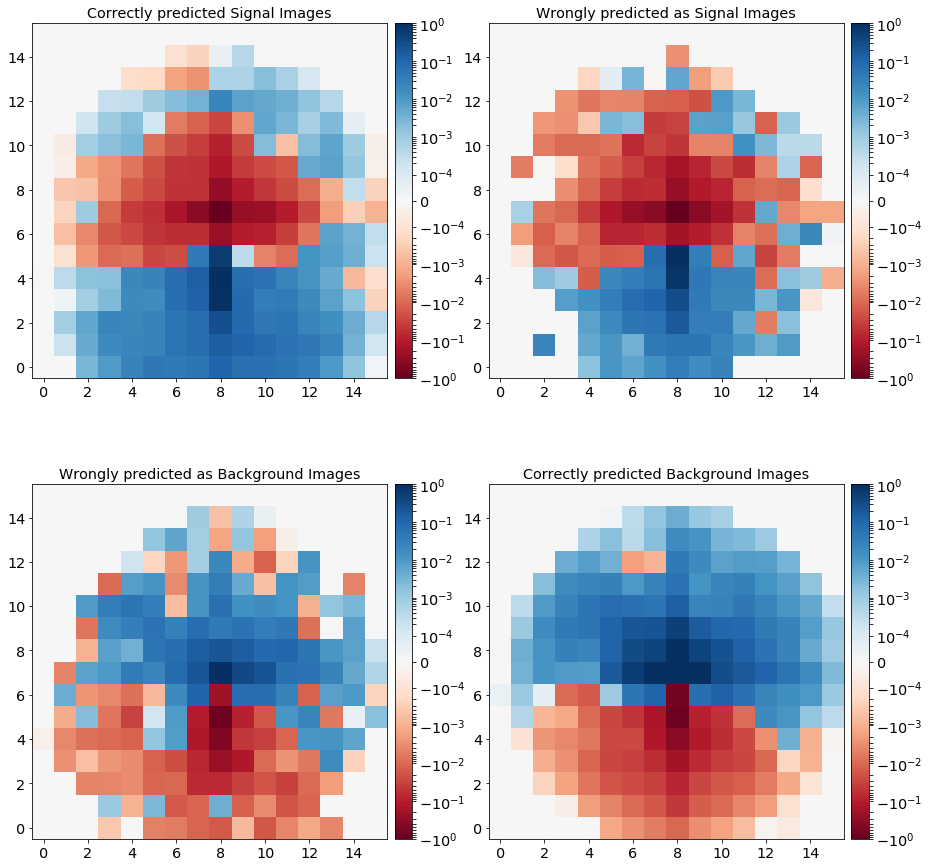

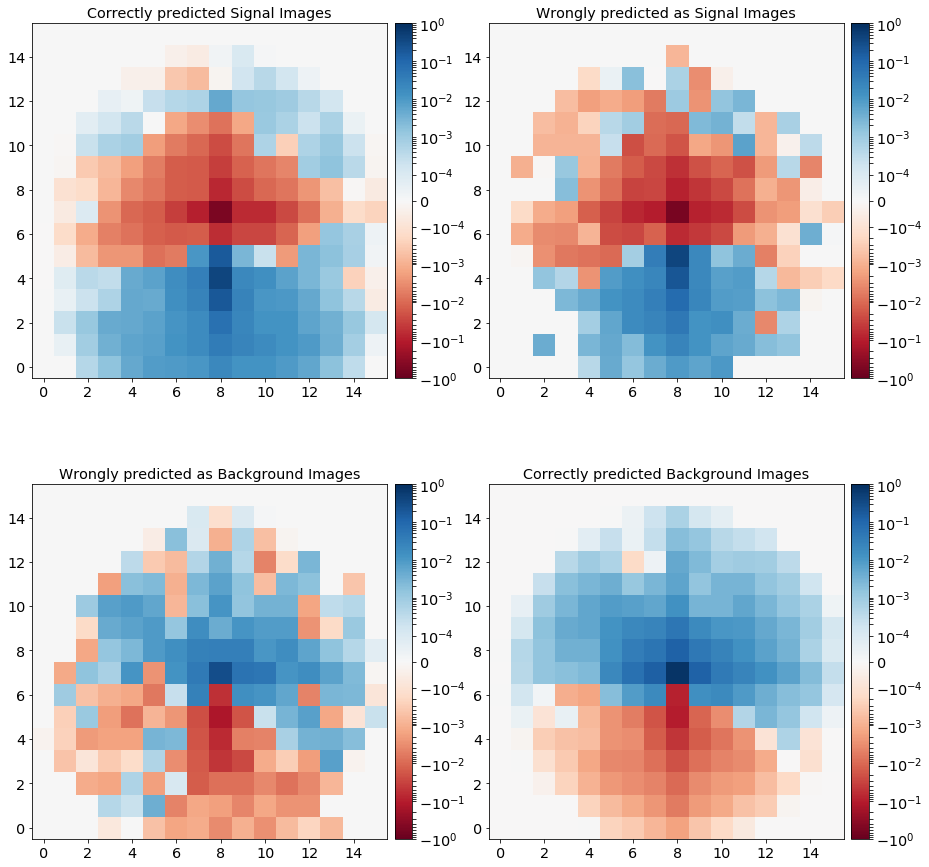

In [32]:
fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(np.mean(pixel_relevance[index1], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[0].set_title("Correctly predicted Signal Images")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(np.mean(pixel_relevance[index2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[1].set_title("Wrongly predicted as Signal Images")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(np.mean(pixel_relevance[index3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[2].set_title("Wrongly predicted as Background Images")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(np.mean(pixel_relevance[index4], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[3].set_title("Correctly predicted Background Images")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

plt.show()

fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(np.mean(norm_image_relevance[index1], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[0].set_title("Correctly predicted Signal Images")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(np.mean(norm_image_relevance[index2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[1].set_title("Wrongly predicted as Signal Images")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(np.mean(norm_image_relevance[index3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[2].set_title("Wrongly predicted as Background Images")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(np.mean(norm_image_relevance[index4], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[3].set_title("Correctly predicted Background Images")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

plt.show()

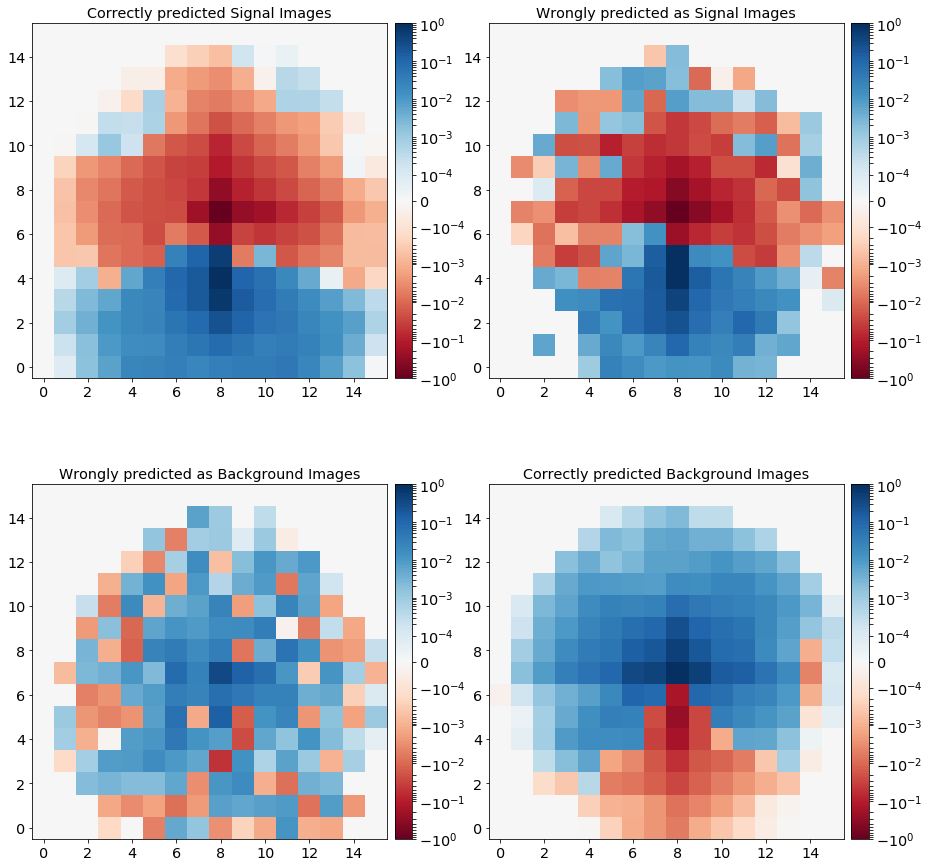

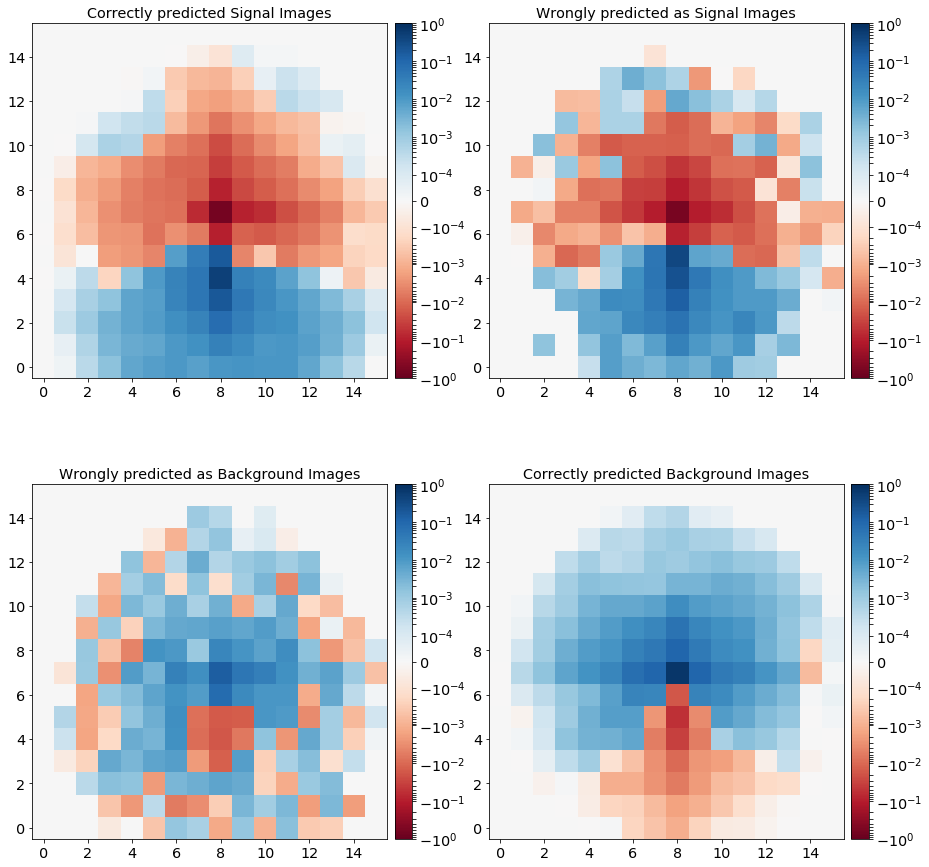

In [33]:
fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(np.mean(pixel_relevance2[index1_2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[0].set_title("Correctly predicted Signal Images")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(np.mean(pixel_relevance2[index2_2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[1].set_title("Wrongly predicted as Signal Images")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(np.mean(pixel_relevance2[index3_2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[2].set_title("Wrongly predicted as Background Images")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(np.mean(pixel_relevance2[index4_2], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[3].set_title("Correctly predicted Background Images")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

plt.show()

fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(np.mean(norm_image_relevance2[index1_2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[0].set_title("Correctly predicted Signal Images")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(np.mean(norm_image_relevance2[index2_2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[1].set_title("Wrongly predicted as Signal Images")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(np.mean(norm_image_relevance2[index3_2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[2].set_title("Wrongly predicted as Background Images")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(np.mean(norm_image_relevance2[index4_2], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[3].set_title("Correctly predicted Background Images")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

plt.show()

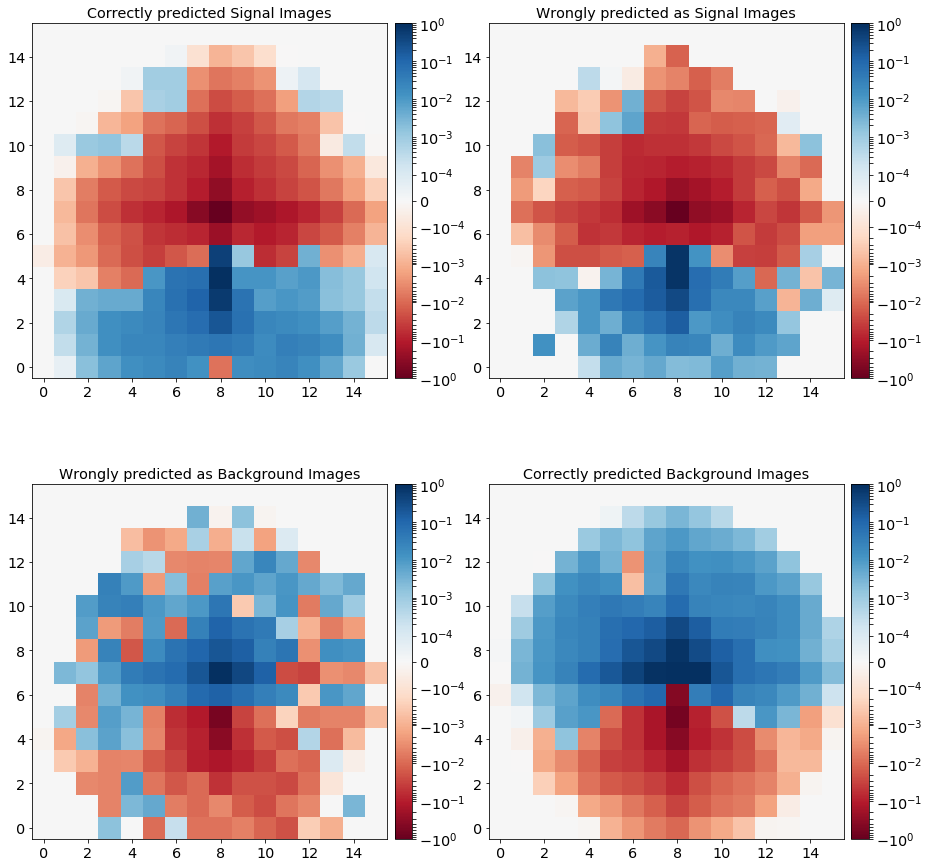

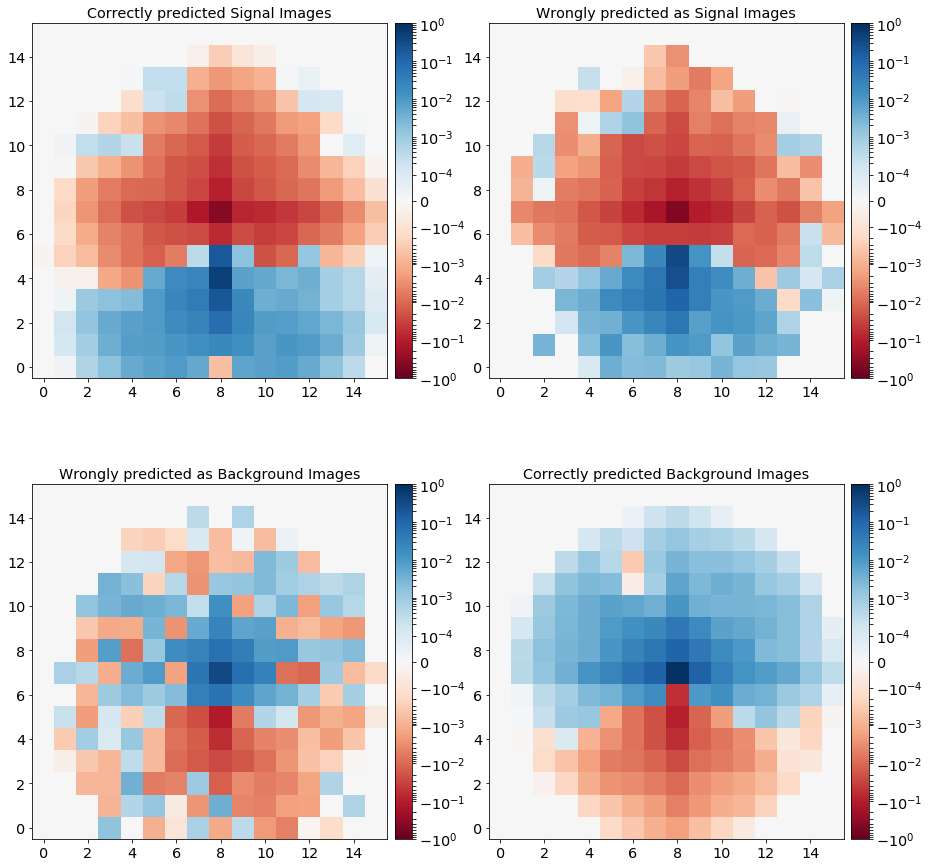

In [34]:
fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(np.mean(pixel_relevance3[index1_3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[0].set_title("Correctly predicted Signal Images")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(np.mean(pixel_relevance3[index2_3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[1].set_title("Wrongly predicted as Signal Images")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(np.mean(pixel_relevance3[index3_3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[2].set_title("Wrongly predicted as Background Images")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(np.mean(pixel_relevance3[index4_3], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[3].set_title("Correctly predicted Background Images")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

plt.show()

fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(np.mean(norm_image_relevance3[index1_3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[0].set_title("Correctly predicted Signal Images")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(np.mean(norm_image_relevance3[index2_3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[1].set_title("Wrongly predicted as Signal Images")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(np.mean(norm_image_relevance3[index3_3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[2].set_title("Wrongly predicted as Background Images")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(np.mean(norm_image_relevance3[index4_3], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[3].set_title("Correctly predicted Background Images")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

plt.show()

In [35]:
# fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
# fig.subplots_adjust(hspace=0.3, wspace =0.2)
# axs=_axs.flatten()
# im =axs[0].imshow(norm_image_relevance[index4][0].squeeze(), cmap='RdBu',interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
# axs[0].set_title("Correctly predicted Background Image")
# fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

# im =axs[1].imshow(norm_image_relevance[index4][10].squeeze(), cmap='RdBu',interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
# axs[1].set_title("Correctly predicted Background Image")
# fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

# im =axs[2].imshow(norm_image_relevance[index4][100].squeeze(), cmap='RdBu',interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
# axs[2].set_title("Correctly predicted Background Image")
# fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

# im =axs[3].imshow(norm_image_relevance[index4][1000].squeeze(), cmap='RdBu', interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
# axs[3].set_title("Correctly predicted Background Image")
# fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

# plt.show()
# fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
# fig.subplots_adjust(hspace=0.3, wspace =0.2)
# axs=_axs.flatten()
# im =axs[0].imshow(norm_image_relevance[index3][0].squeeze(), cmap='RdBu',interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
# axs[0].set_title("Wrongly predicted Background Image")
# fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

# im =axs[1].imshow(norm_image_relevance[index3][1].squeeze(), cmap='RdBu',interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
# axs[1].set_title("Wrongly predicted Background Image")
# fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

# im =axs[2].imshow(norm_image_relevance[index3][2].squeeze(), cmap='RdBu',interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
# axs[2].set_title("Wrongly predicted Background Image")
# fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

# im =axs[3].imshow(norm_image_relevance[index3][3].squeeze(), cmap='RdBu', interpolation='nearest',
#                 norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
# axs[3].set_title("Wrongly predicted Background Image")
# fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

# plt.show()

# LRP-$\epsilon$

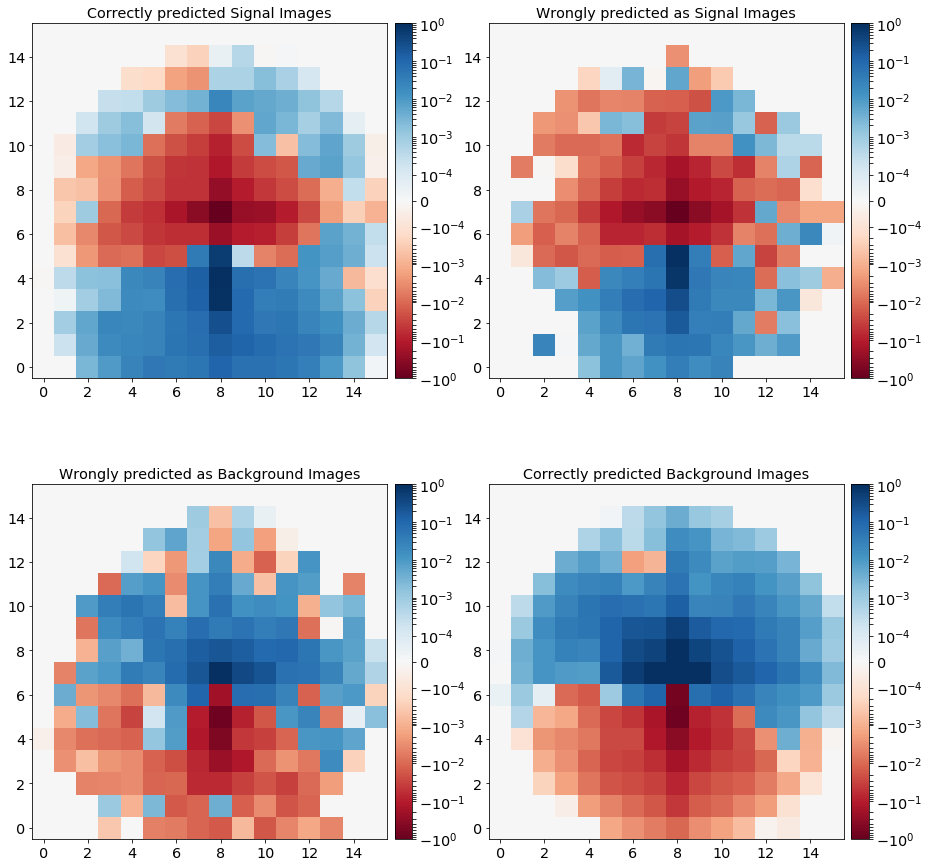

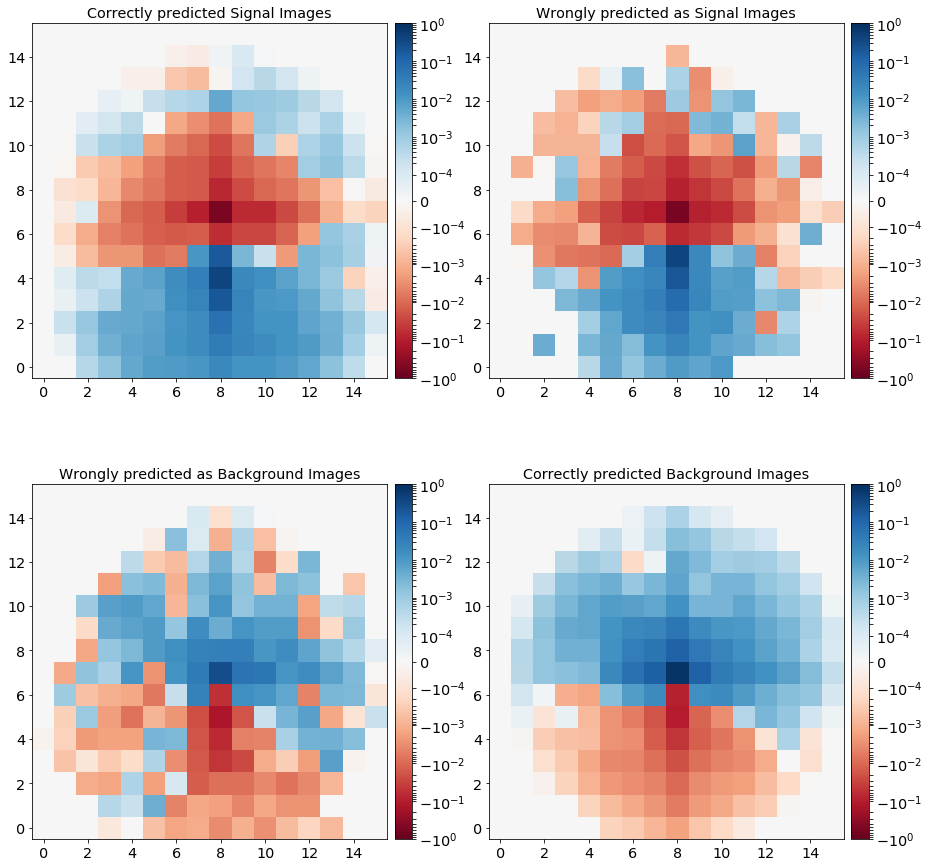

In [36]:
fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(np.mean(e_pixel_relevance[index1], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[0].set_title("Correctly predicted Signal Images")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(np.mean(e_pixel_relevance[index2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[1].set_title("Wrongly predicted as Signal Images")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(np.mean(e_pixel_relevance[index3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[2].set_title("Wrongly predicted as Background Images")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(np.mean(e_pixel_relevance[index4], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[3].set_title("Correctly predicted Background Images")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

plt.show()

fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(np.mean(e_norm_image_relevance[index1], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[0].set_title("Correctly predicted Signal Images")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(np.mean(e_norm_image_relevance[index2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[1].set_title("Wrongly predicted as Signal Images")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(np.mean(e_norm_image_relevance[index3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[2].set_title("Wrongly predicted as Background Images")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(np.mean(e_norm_image_relevance[index4], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[3].set_title("Correctly predicted Background Images")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

plt.show()

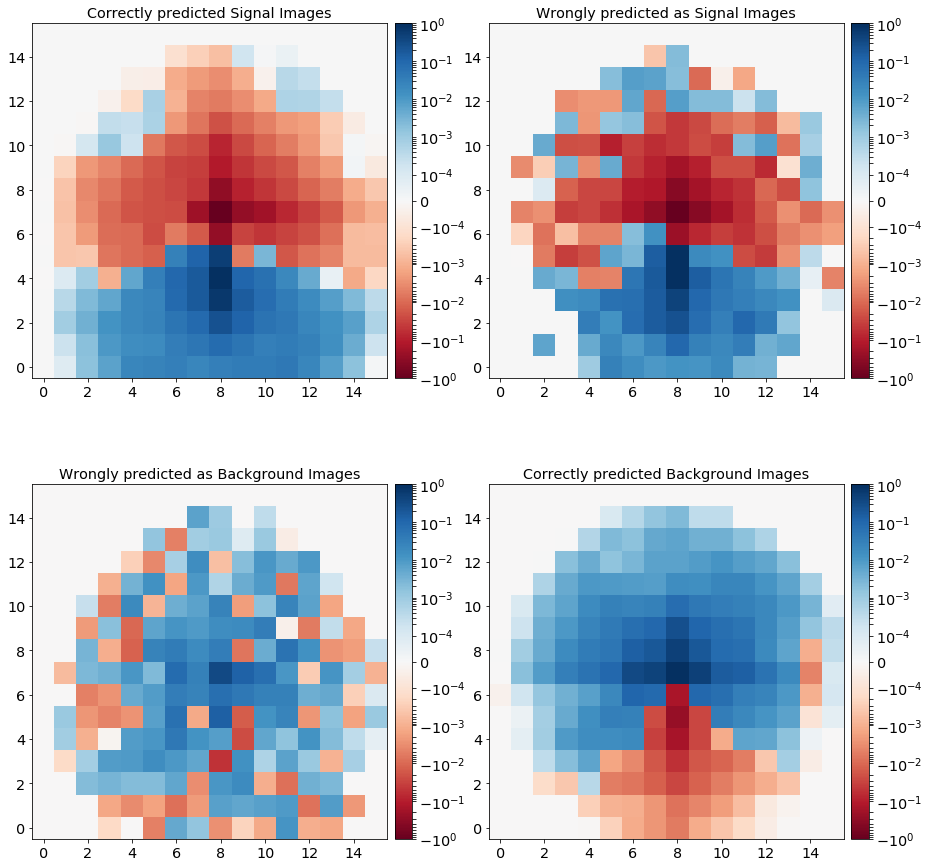

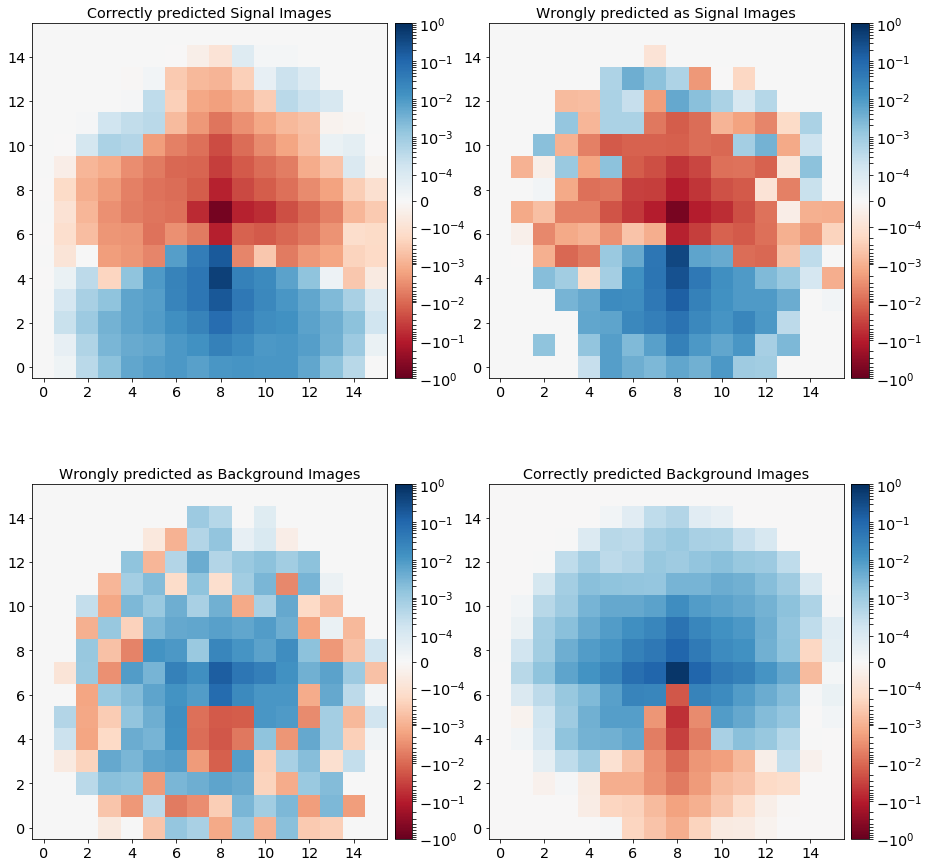

In [37]:
fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(np.mean(e_pixel_relevance2[index1_2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[0].set_title("Correctly predicted Signal Images")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(np.mean(e_pixel_relevance2[index2_2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[1].set_title("Wrongly predicted as Signal Images")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(np.mean(e_pixel_relevance2[index3_2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[2].set_title("Wrongly predicted as Background Images")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(np.mean(e_pixel_relevance2[index4_2], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[3].set_title("Correctly predicted Background Images")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

plt.show()

fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(np.mean(e_norm_image_relevance2[index1_2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[0].set_title("Correctly predicted Signal Images")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(np.mean(e_norm_image_relevance2[index2_2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[1].set_title("Wrongly predicted as Signal Images")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(np.mean(e_norm_image_relevance2[index3_2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[2].set_title("Wrongly predicted as Background Images")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(np.mean(e_norm_image_relevance2[index4_2], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[3].set_title("Correctly predicted Background Images")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

plt.show()

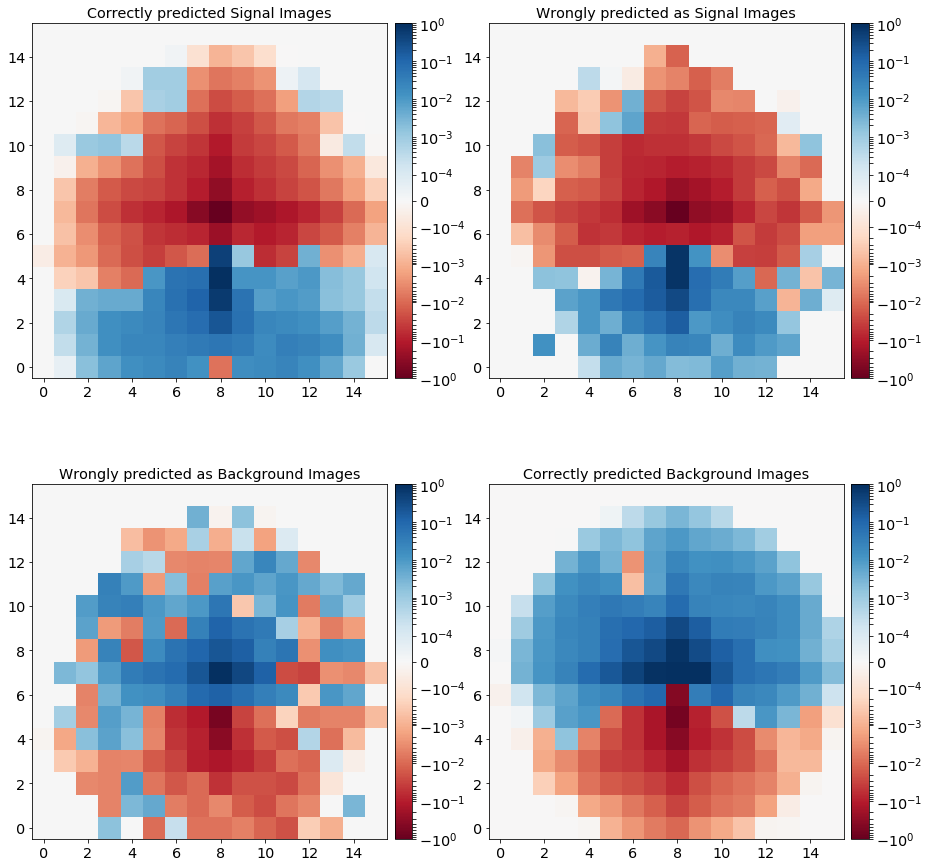

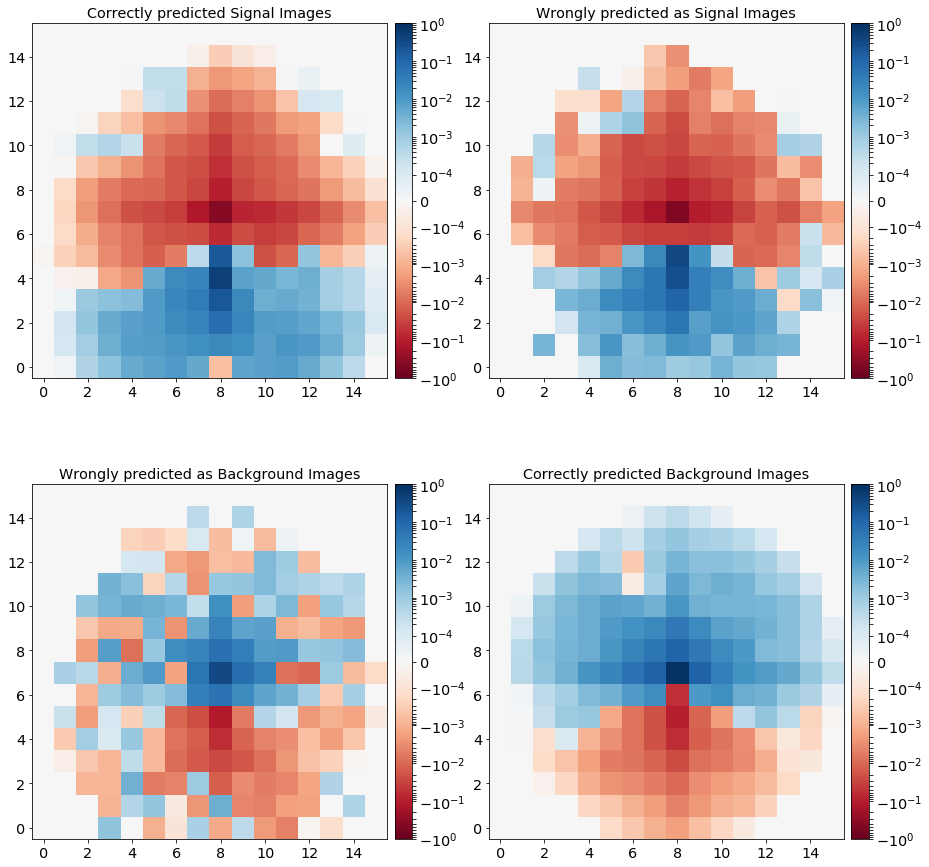

In [38]:
fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(np.mean(e_pixel_relevance3[index1_3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[0].set_title("Correctly predicted Signal Images")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(np.mean(e_pixel_relevance3[index2_3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[1].set_title("Wrongly predicted as Signal Images")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(np.mean(e_pixel_relevance3[index3_3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[2].set_title("Wrongly predicted as Background Images")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(np.mean(e_pixel_relevance3[index4_3], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[3].set_title("Correctly predicted Background Images")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

plt.show()

fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(np.mean(e_norm_image_relevance3[index1_3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[0].set_title("Correctly predicted Signal Images")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(np.mean(e_norm_image_relevance3[index2_3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[1].set_title("Wrongly predicted as Signal Images")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(np.mean(e_norm_image_relevance3[index3_3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[2].set_title("Wrongly predicted as Background Images")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(np.mean(e_norm_image_relevance3[index4_3], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[3].set_title("Correctly predicted Background Images")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

plt.show()

# LRP-$\alpha_1 \beta_0$

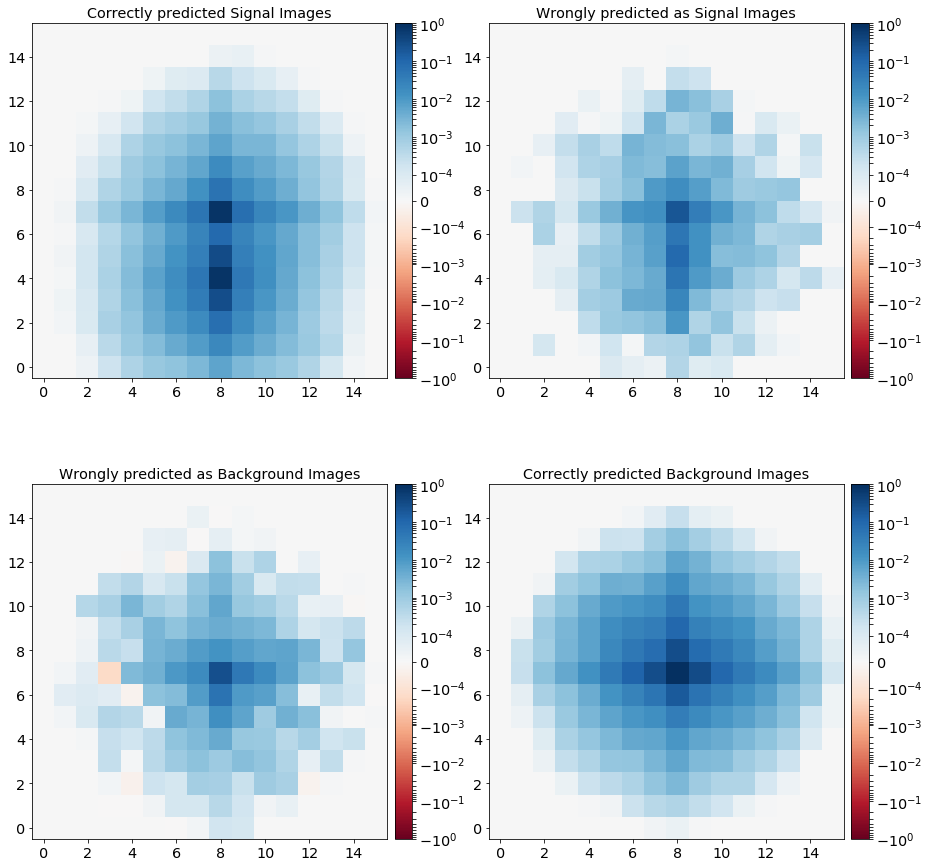

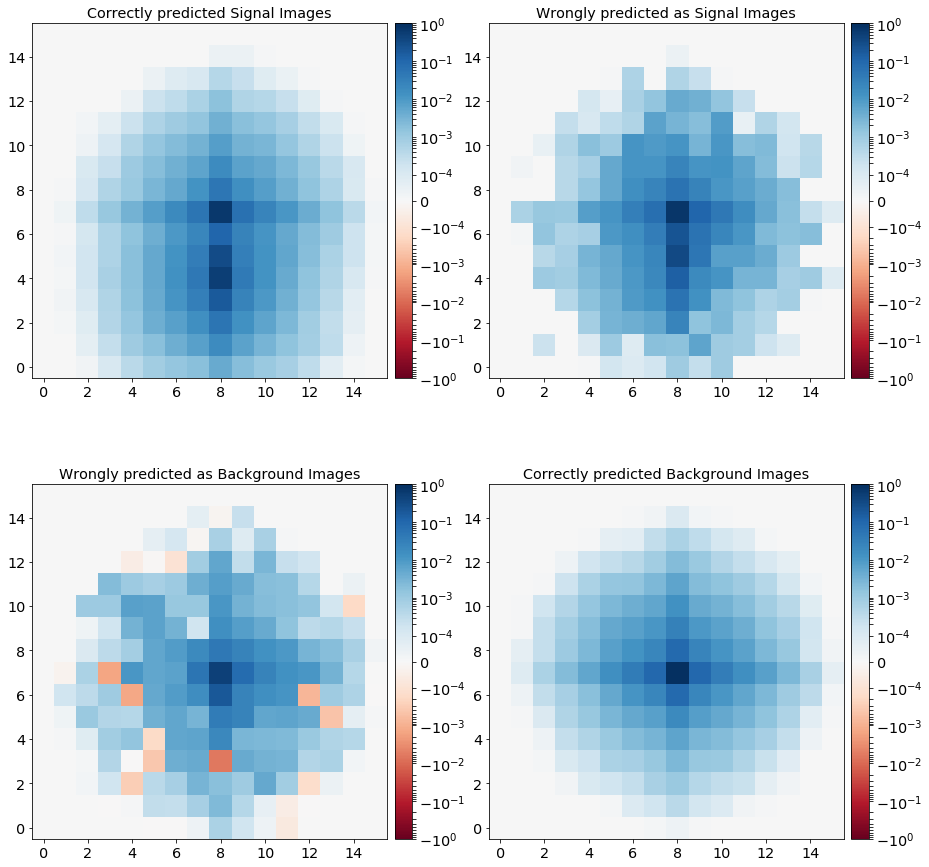

In [39]:
fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(np.mean(g_pixel_relevance[index1], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[0].set_title("Correctly predicted Signal Images")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(np.mean(g_pixel_relevance[index2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[1].set_title("Wrongly predicted as Signal Images")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(np.mean(g_pixel_relevance[index3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[2].set_title("Wrongly predicted as Background Images")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(np.mean(g_pixel_relevance[index4], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[3].set_title("Correctly predicted Background Images")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

plt.show()

fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(np.mean(g_norm_image_relevance[index1], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[0].set_title("Correctly predicted Signal Images")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(np.mean(g_norm_image_relevance[index2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[1].set_title("Wrongly predicted as Signal Images")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(np.mean(g_norm_image_relevance[index3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[2].set_title("Wrongly predicted as Background Images")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(np.mean(g_norm_image_relevance[index4], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[3].set_title("Correctly predicted Background Images")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

plt.show()

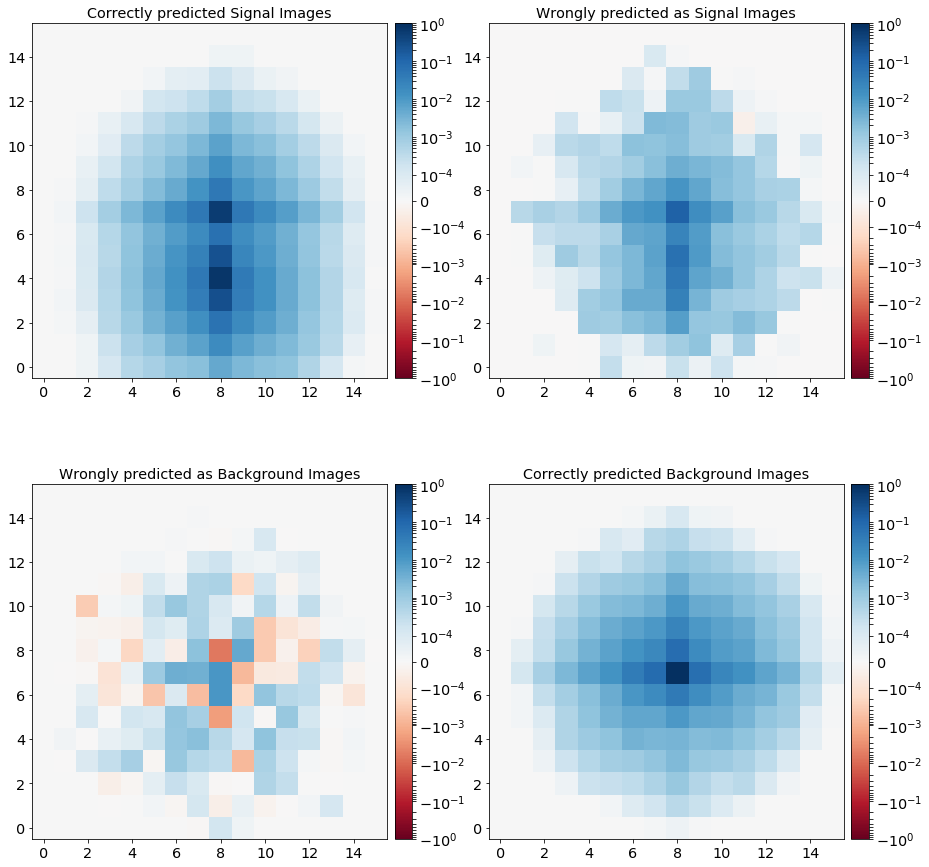

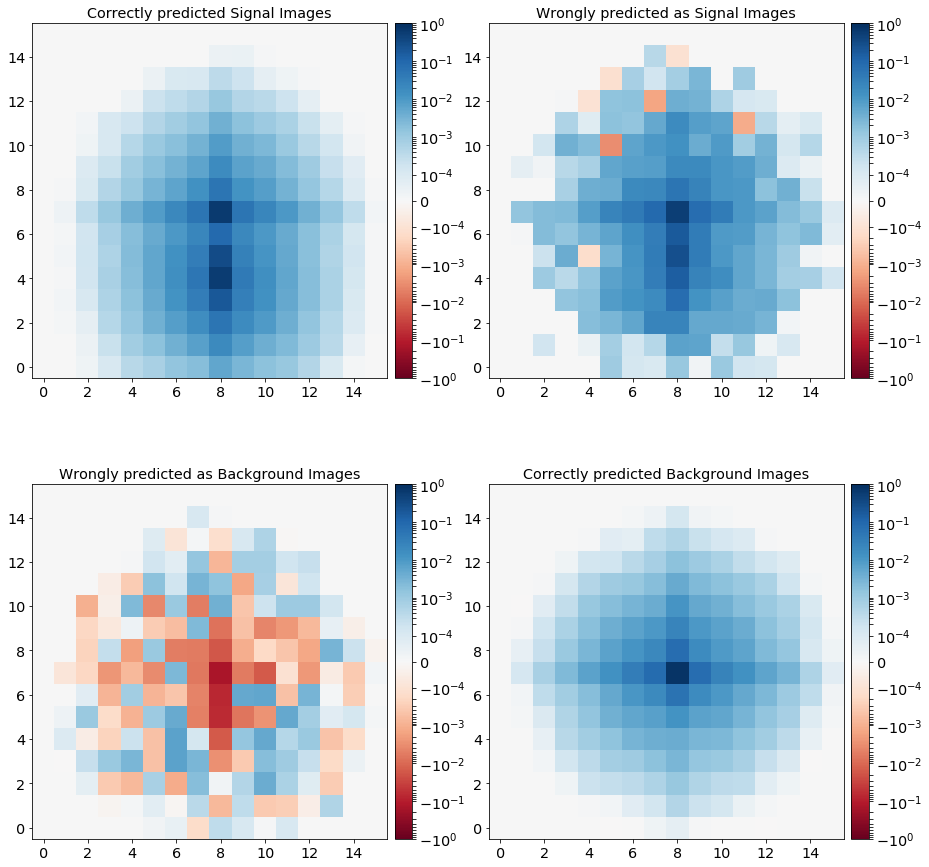

In [40]:
fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(np.mean(g_pixel_relevance2[index1_2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[0].set_title("Correctly predicted Signal Images")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(np.mean(g_pixel_relevance2[index2_2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[1].set_title("Wrongly predicted as Signal Images")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(np.mean(g_pixel_relevance2[index3_2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[2].set_title("Wrongly predicted as Background Images")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(np.mean(g_pixel_relevance2[index4_2], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[3].set_title("Correctly predicted Background Images")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

plt.show()

fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(np.mean(g_norm_image_relevance2[index1_2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[0].set_title("Correctly predicted Signal Images")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(np.mean(g_norm_image_relevance2[index2_2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[1].set_title("Wrongly predicted as Signal Images")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(np.mean(g_norm_image_relevance2[index3_2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[2].set_title("Wrongly predicted as Background Images")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(np.mean(g_norm_image_relevance2[index4_2], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[3].set_title("Correctly predicted Background Images")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

plt.show()

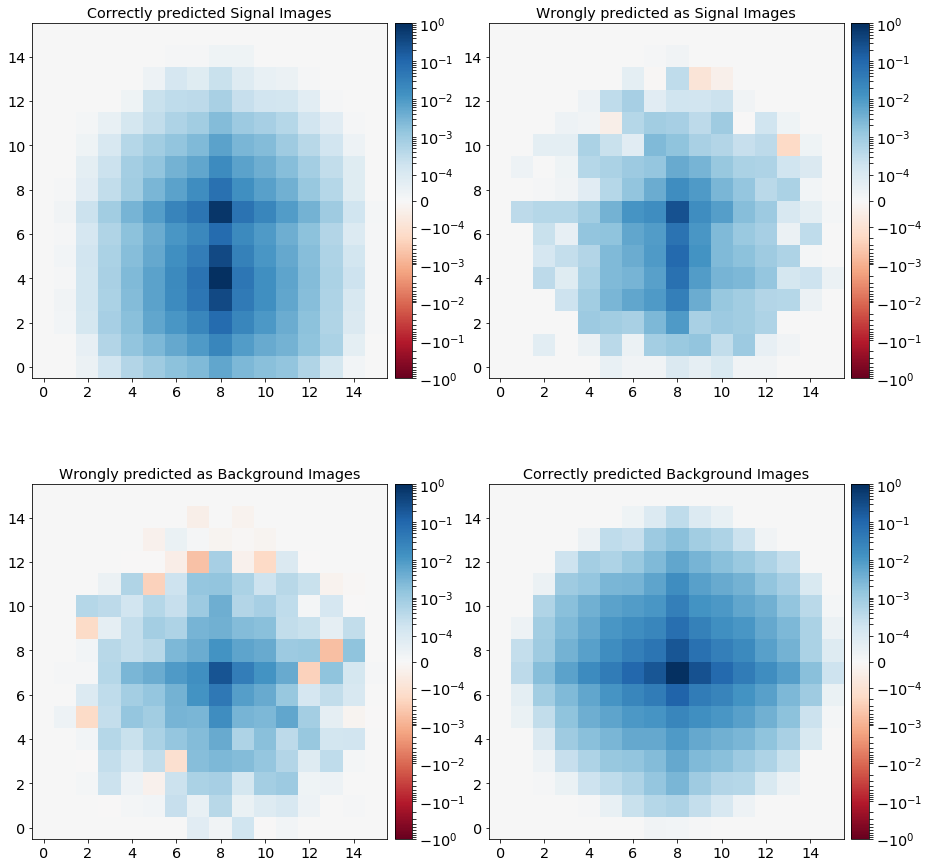

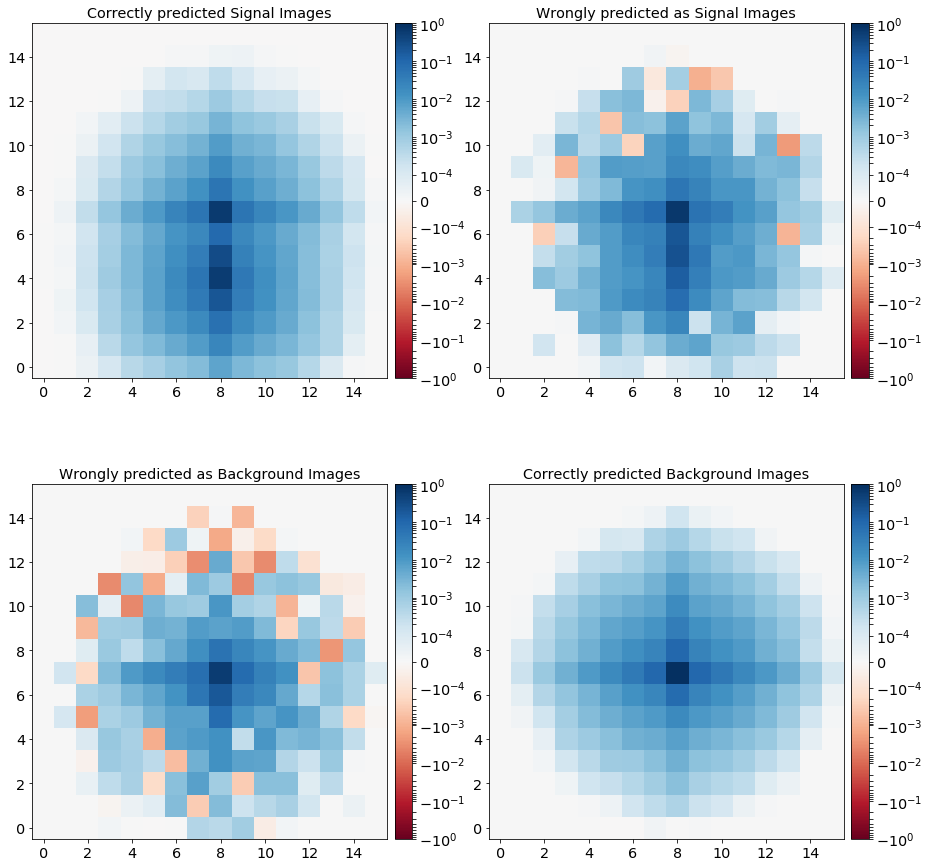

In [41]:
fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(np.mean(g_pixel_relevance3[index1_3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[0].set_title("Correctly predicted Signal Images")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(np.mean(g_pixel_relevance3[index2_3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[1].set_title("Wrongly predicted as Signal Images")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(np.mean(g_pixel_relevance3[index3_3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[2].set_title("Wrongly predicted as Background Images")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(np.mean(g_pixel_relevance3[index4_3], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[3].set_title("Correctly predicted Background Images")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

plt.show()

fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(np.mean(g_norm_image_relevance3[index1_3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[0].set_title("Correctly predicted Signal Images")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(np.mean(g_norm_image_relevance3[index2_3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[1].set_title("Wrongly predicted as Signal Images")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(np.mean(g_norm_image_relevance3[index3_3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[2].set_title("Wrongly predicted as Background Images")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(np.mean(g_norm_image_relevance3[index4_3], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[3].set_title("Correctly predicted Background Images")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

plt.show()

# LRP-PresetA

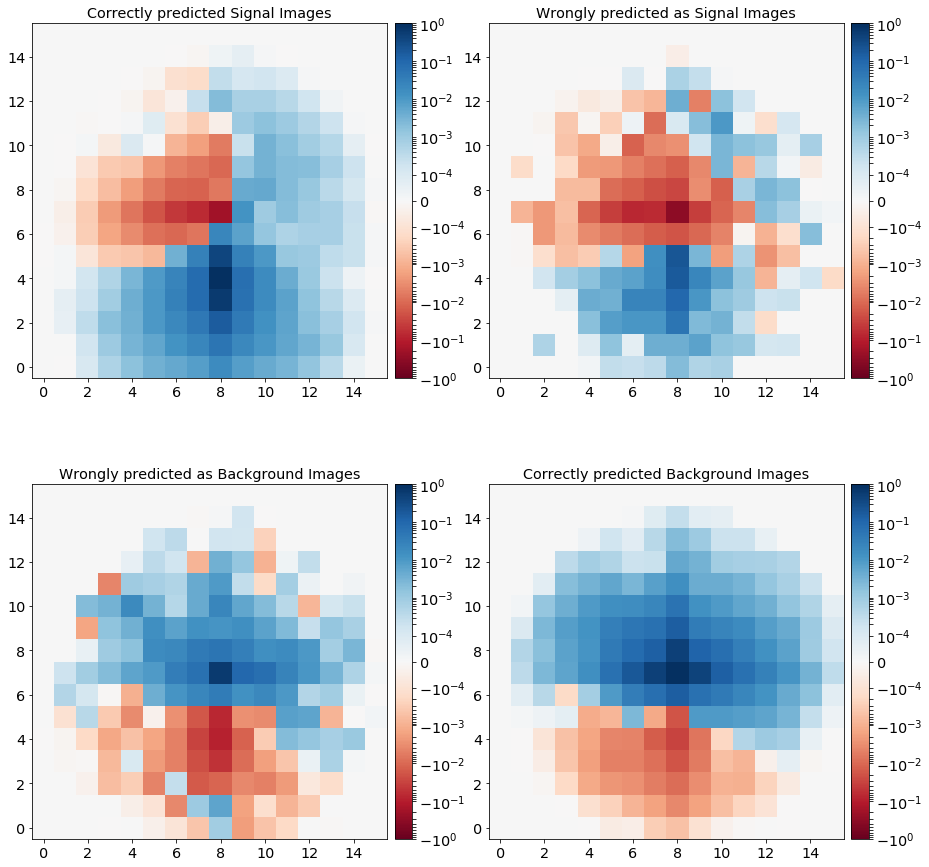

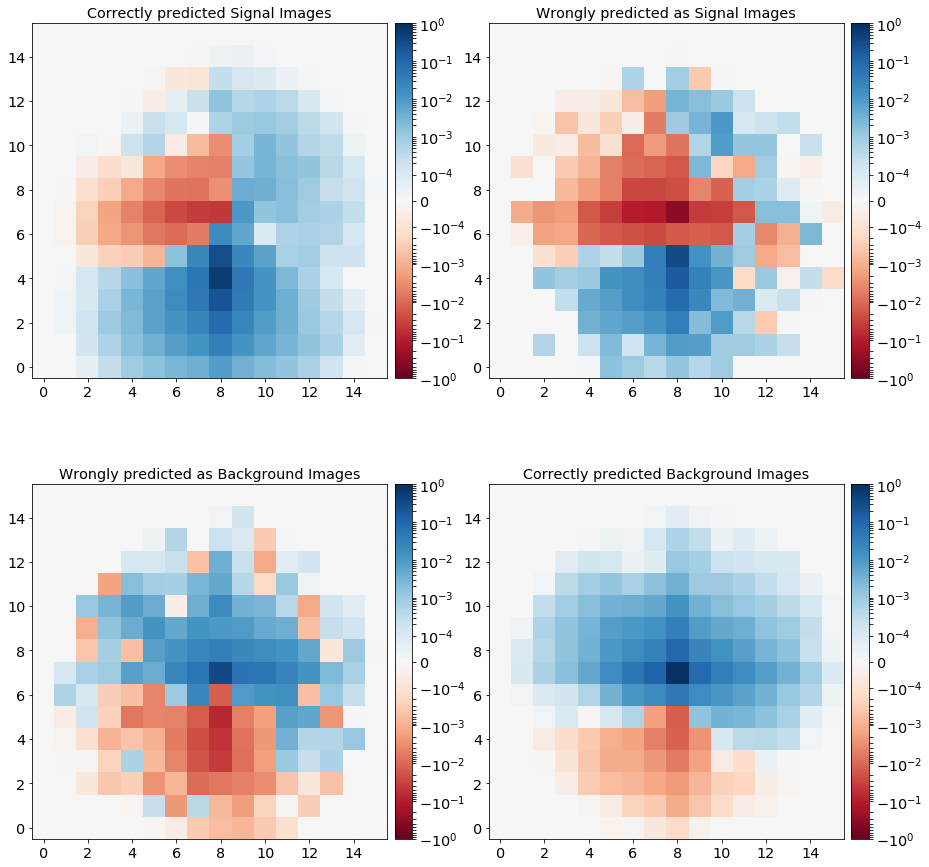

In [42]:
fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(np.mean(p_pixel_relevance[index1], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[0].set_title("Correctly predicted Signal Images")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(np.mean(p_pixel_relevance[index2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[1].set_title("Wrongly predicted as Signal Images")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(np.mean(p_pixel_relevance[index3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[2].set_title("Wrongly predicted as Background Images")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(np.mean(p_pixel_relevance[index4], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[3].set_title("Correctly predicted Background Images")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

plt.show()

fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(np.mean(p_norm_image_relevance[index1], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[0].set_title("Correctly predicted Signal Images")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(np.mean(p_norm_image_relevance[index2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[1].set_title("Wrongly predicted as Signal Images")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(np.mean(p_norm_image_relevance[index3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[2].set_title("Wrongly predicted as Background Images")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(np.mean(p_norm_image_relevance[index4], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[3].set_title("Correctly predicted Background Images")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

plt.show()

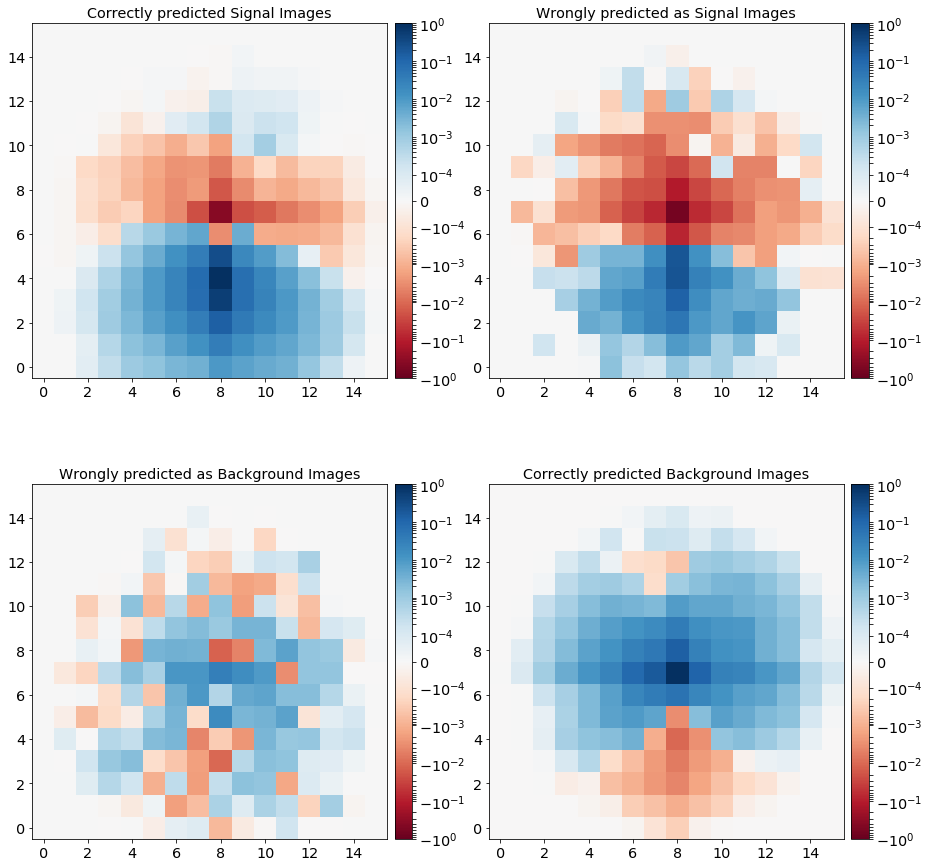

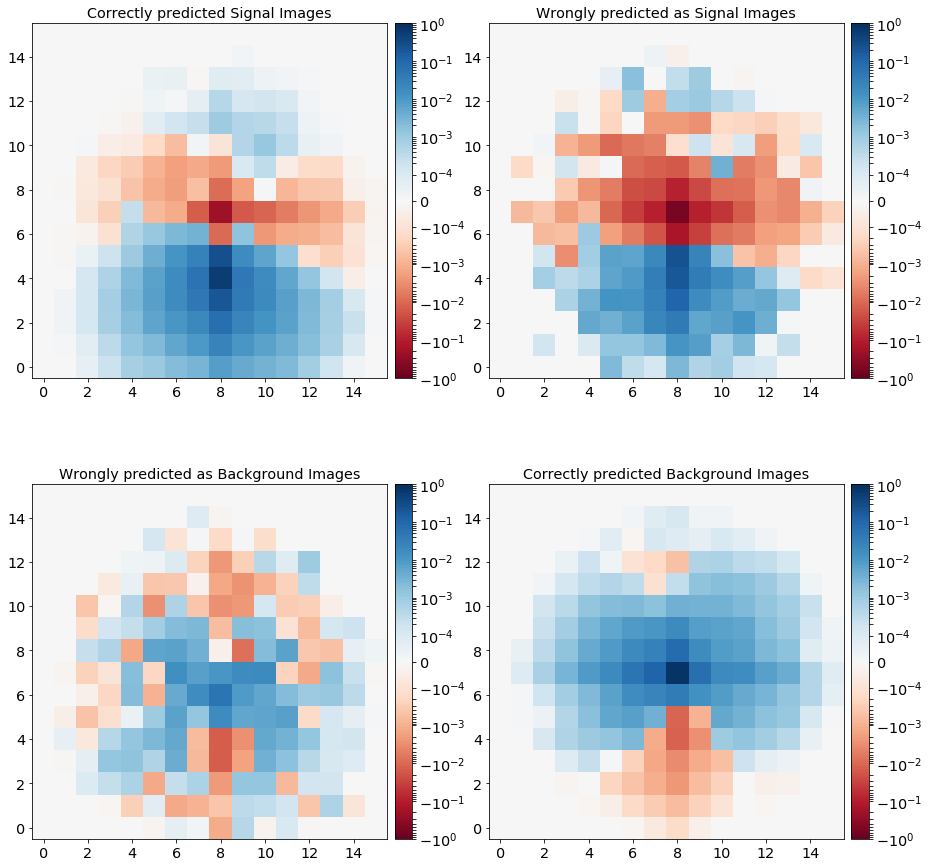

In [43]:
fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(np.mean(p_pixel_relevance2[index1_2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[0].set_title("Correctly predicted Signal Images")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(np.mean(p_pixel_relevance2[index2_2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[1].set_title("Wrongly predicted as Signal Images")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(np.mean(p_pixel_relevance2[index3_2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[2].set_title("Wrongly predicted as Background Images")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(np.mean(p_pixel_relevance2[index4_2], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[3].set_title("Correctly predicted Background Images")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

plt.show()

fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(np.mean(p_norm_image_relevance2[index1_2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[0].set_title("Correctly predicted Signal Images")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(np.mean(p_norm_image_relevance2[index2_2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[1].set_title("Wrongly predicted as Signal Images")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(np.mean(p_norm_image_relevance2[index3_2], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[2].set_title("Wrongly predicted as Background Images")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(np.mean(p_norm_image_relevance2[index4_2], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[3].set_title("Correctly predicted Background Images")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

plt.show()

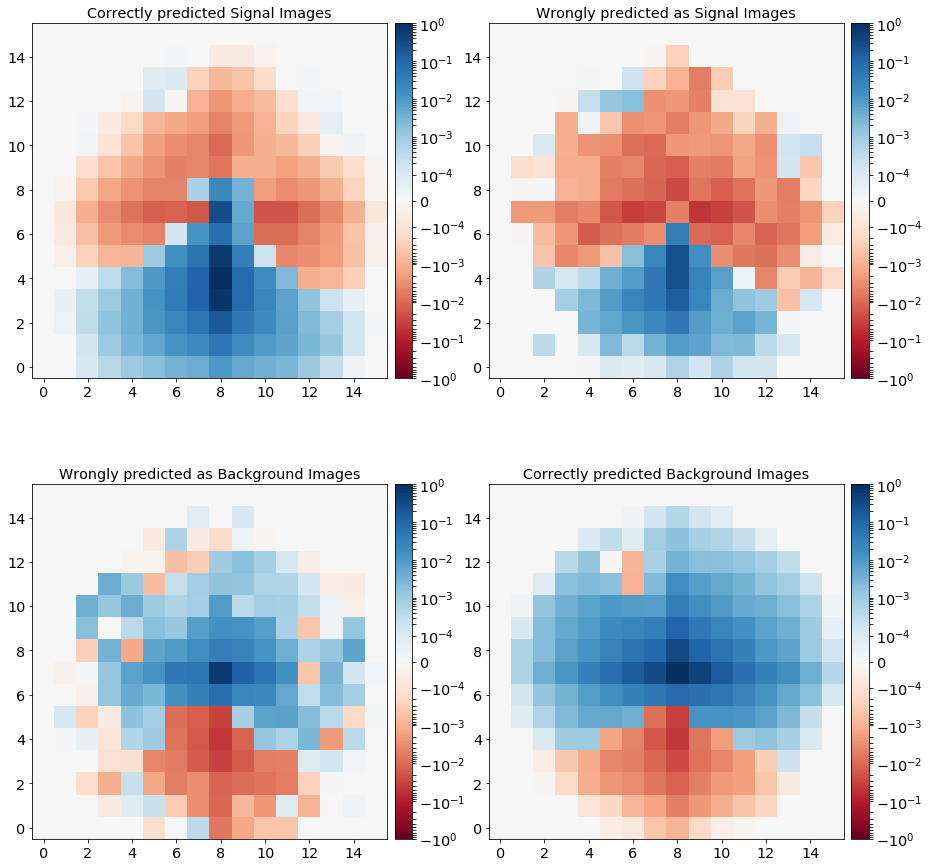

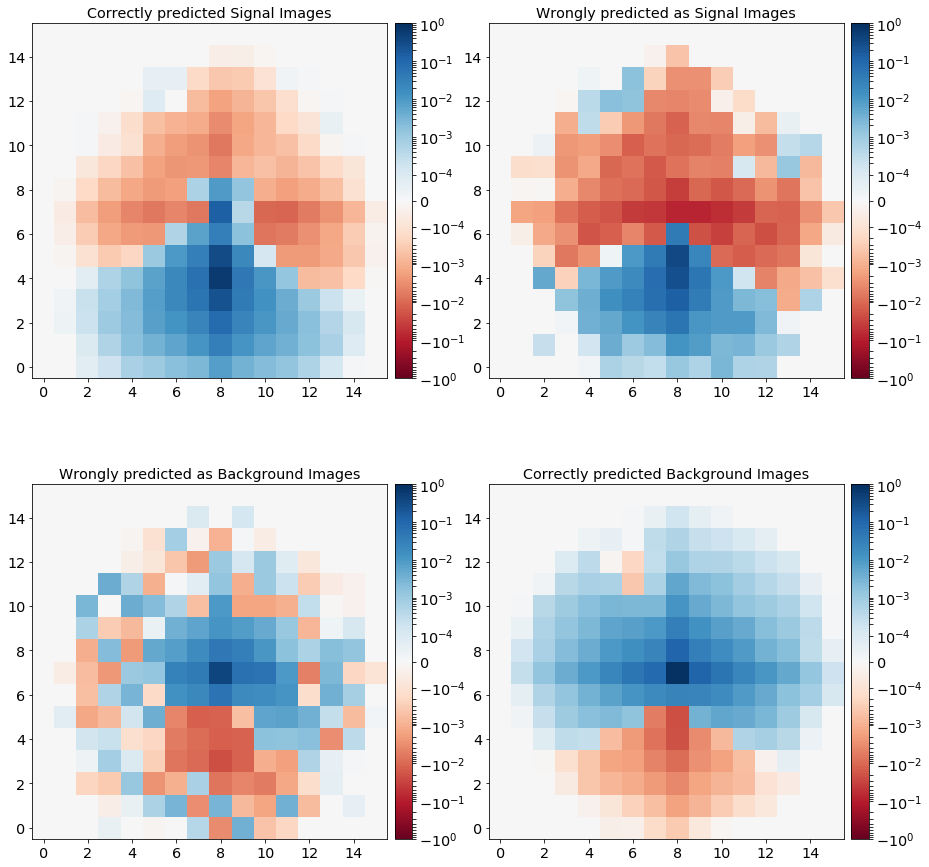

In [44]:
fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(np.mean(p_pixel_relevance3[index1_3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[0].set_title("Correctly predicted Signal Images")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(np.mean(p_pixel_relevance3[index2_3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[1].set_title("Wrongly predicted as Signal Images")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(np.mean(p_pixel_relevance3[index3_3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[2].set_title("Wrongly predicted as Background Images")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(np.mean(p_pixel_relevance3[index4_3], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[3].set_title("Correctly predicted Background Images")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

plt.show()

fig, _axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace =0.2)
axs=_axs.flatten()

im =axs[0].imshow(np.mean(p_norm_image_relevance3[index1_3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[0].set_title("Correctly predicted Signal Images")
fig.colorbar(im, ax=axs[0], fraction=0.0467, pad=0.02)

im =axs[1].imshow(np.mean(p_norm_image_relevance3[index2_3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[1].set_title("Wrongly predicted as Signal Images")
fig.colorbar(im, ax=axs[1], fraction=0.0467, pad=0.02)

im =axs[2].imshow(np.mean(p_norm_image_relevance3[index3_3], axis=0).squeeze(), cmap='RdBu',interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[2].set_title("Wrongly predicted as Background Images")
fig.colorbar(im, ax=axs[2], fraction=0.0467, pad=0.02)

im =axs[3].imshow(np.mean(p_norm_image_relevance3[index4_3], axis=0).squeeze(), cmap='RdBu', interpolation='nearest',
                norm=SymLogNorm(linthresh=0.0001), vmin = -1, vmax= 1, origin='low')
axs[3].set_title("Correctly predicted Background Images")
fig.colorbar(im, ax=axs[3], fraction=0.0467, pad=0.02)

plt.show()